# Danh sách thành viên:

| MSSV|Họ và tên|
| ----------- | ----------- |
|20133029|Nguyễn Trí Dũng|
|20133090|Nguyễn Khoa Quang Thắng|
|20133076|Văn Mai Thanh Nhật|
|20133082|Huỳnh Minh Phước|

# Khai phá dữ liệu giao dịch của Website bán hàng

# Thư viện sử dụng

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from itertools import repeat
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
from os.path import exists
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

# Thông tin tập dữ liệu

Link của tập dữ liệu: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?select=Sales+Transaction+v.4a.csv

Tác giả: Gabriel Ramos

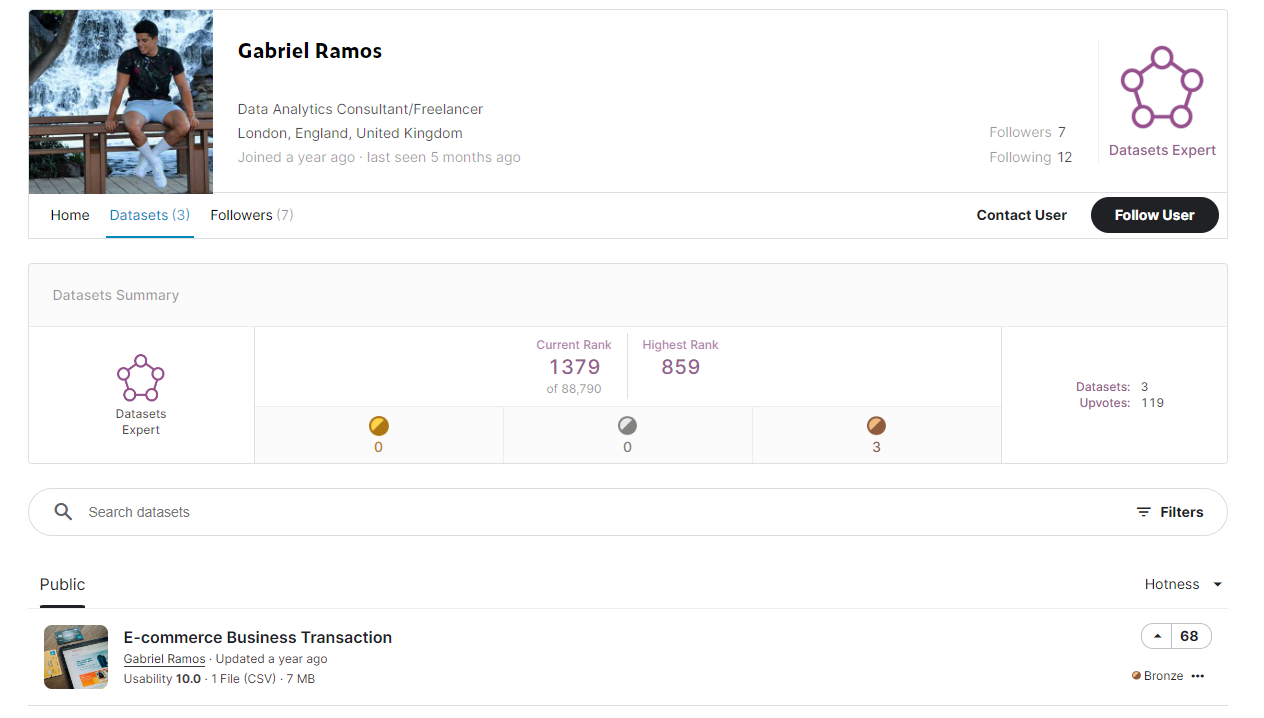

This is a sales transaction data set of UK-based e-commerce (online retail) for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.

In [202]:
data = pd.read_csv("./data/SalesTransaction.csv")

In [203]:
#data = data.head(10000)

Các attribute của tập dữ liệu:


The data set contains 500K rows and 8 columns. The following is the description of each column.

1. **TransactionNo (categorical):** a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.

2. **Date (numeric):** the date when each transaction was generated.

3. **ProductNo (categorical):** a five or six-digit unique character used to identify a specific product.

4. **Product (categorical):** product/item name.

5. **Price (numeric):** the price of each product per unit in pound sterling (£).

6. **Quantity (numeric):** the quantity of each product per transaction. Negative values related to cancelled transactions.

7. **CustomerNo (categorical):** a five-digit unique number that defines each customer.

8. **Country (categorical):** name of the country where the customer resides.

There is a small percentage of order cancellation in the data set. Most of these cancellations were due to out-of-stock conditions on some 
products. Under this situation, customers tend to cancel an order as they want all products delivered all at once.


# 1. Làm sạch dữ liệu:

## Xem 5 dòng đầu của tập dữ liệu:

In [204]:
data.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


## Xem thông tin của tập dữ liệu:

In [205]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [206]:
data.shape

(536350, 8)

## Kiểm tra có dòng nào bị thiếu dữ liệu:

Có tổng cộng 55 dòng bị thiếu mất CustomerNo, nên ta sẽ xử lí 55 dòng bằng cách loại bỏ

In [207]:
data.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

In [208]:
data.dropna(inplace=True)

In [209]:
data["CustomerNo"] = data["CustomerNo"].astype(str)
dateFormat = '%m/%d/%Y'
data['Date'] = pd.to_datetime(data['Date'],format = dateFormat)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536295 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  536295 non-null  object        
 1   Date           536295 non-null  datetime64[ns]
 2   ProductNo      536295 non-null  object        
 3   ProductName    536295 non-null  object        
 4   Price          536295 non-null  float64       
 5   Quantity       536295 non-null  int64         
 6   CustomerNo     536295 non-null  object        
 7   Country        536295 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.8+ MB


# EDA

In [210]:
data["TotalMoney"] = data['Price']*data['Quantity']
data['Month'] = pd.DatetimeIndex(data['Date']).month
data['Year'] = pd.DatetimeIndex(data['Date']).year

## Số lượng của transaction bị huỷ

Lọc những transaction bị huỷ khỏi data và lưu lại vào CSV:

In [211]:
data_CancelTransaction = data.loc[data['Quantity']<0]
data_CancelTransaction.head()
data_CancelTransaction.to_csv('./data/data_CancelTransaction.csv')
data = data.loc[~(data['Quantity']<0)]

Tính tổng số tiền chi tiêu của mỗi khách hàng:

In [212]:
if not exists("./data/customer_quantity_price.csv"):
    customer_quantity_price = []
    for i in data['CustomerNo'].unique():
        sum_Quantity = data.loc[data['CustomerNo'] == i].Quantity.sum()
        sum_Price = data.loc[data['CustomerNo'] == i].TotalMoney.sum()
        customer_quantity_price.append([i, sum_Quantity,sum_Price])
    customer_quantity_price = pd.DataFrame(data=customer_quantity_price)
    customer_quantity_price.columns = ["CustomerNo", "TotalQuantity","TotalMoney"]
    customer_quantity_price.to_csv("./data/customer_quantity_price.csv",index=False)
else: customer_quantity_price = pd.read_csv("./data/customer_quantity_price.csv")

In [213]:
customer_quantity_price.head()

,CustomerNo,TotalQuantity,TotalMoney
0,17490,1134,13538.07
1,13069,5885,63353.94
2,12433,11062,115454.49
3,13426,2245,25893.59
4,17364,2701,30254.25


Trực quan hoá số tiền chi tiêu của mỗi khách hàng:

<Axes: xlabel='TotalQuantity'>

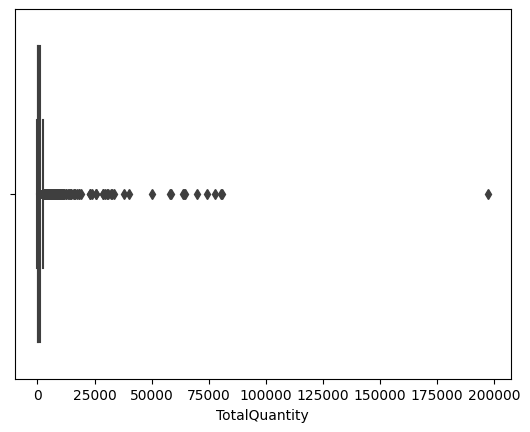

In [214]:
sb.boxplot(x='TotalQuantity',data=customer_quantity_price)

# Tìm các khách hàng là outlier dựa theo TotalMoney và Quantity

## Tìm outlier theo phương pháp statistic:

Tính Q1, Q3, IQR theo TotalQuantity:

In [215]:
Q1_TotalQuantity = customer_quantity_price.TotalQuantity.quantile(0.25)
Q3_TotalQuantity = customer_quantity_price.TotalQuantity.quantile(0.75)
IQR_TotalQuantity = Q3_TotalQuantity - Q1_TotalQuantity
print("Q1_TotalQuantity:  ",Q1_TotalQuantity)
print("Q3_TotalQuantity: ",Q3_TotalQuantity)
print("IQR_TotalQuantity: ",IQR_TotalQuantity)

Q1_TotalQuantity:   158.0
Q3_TotalQuantity:  1041.75
IQR_TotalQuantity:  883.75


In [216]:
Q1_TotalMoney = customer_quantity_price.TotalMoney.quantile(0.25)
Q3_TotalMoney = customer_quantity_price.TotalMoney.quantile(0.75)
IQR_TotalMoney = Q3_TotalMoney - Q1_TotalMoney
print("Q1_TotalMoney: ",Q1_TotalMoney)
print("Q3_TotalMoney: ",Q3_TotalMoney)
print("IQR_TotalMoney: ",IQR_TotalMoney)

Q1_TotalMoney:  1838.4475
Q3_TotalMoney:  11906.285
IQR_TotalMoney:  10067.8375


Tìm outlier và xuất ra CSV:

In [217]:
customer_quantity_price_outlier_statistic = customer_quantity_price.loc[(customer_quantity_price["TotalQuantity"] < Q1_TotalQuantity-1.5*IQR_TotalQuantity) | (customer_quantity_price["TotalQuantity"] > Q3_TotalQuantity+1.5*IQR_TotalQuantity)].sort_values(by="TotalQuantity",ascending=False)
customer_quantity_price_outlier_statistic.append(customer_quantity_price.loc[(customer_quantity_price["TotalMoney"] < Q1_TotalMoney-1.5*IQR_TotalMoney) | (customer_quantity_price["TotalMoney"] > Q3_TotalMoney+1.5*IQR_TotalMoney)].sort_values(by="TotalMoney",ascending=False))
print("Tổng số outlier: ",len(customer_quantity_price_outlier_statistic))

customer_quantity_price_outlier_statistic.to_csv("./data/customer_quantity_price_outlier_statistic.csv",index=False)

Tổng số outlier:  409


## Tìm outlier theo phương pháp xấp xỉ:

### Thuật toán DBSCAN

Chọn minPts > Dimension +1 => minPts = 4

Chọn eps:

In [218]:
input = customer_quantity_price.iloc[:,1:4]
input.head()

,TotalQuantity,TotalMoney
0,1134,13538.07
1,5885,63353.94
2,11062,115454.49
3,2245,25893.59
4,2701,30254.25


In [219]:
neighb = NearestNeighbors(n_neighbors=100) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(input) # fitting the data to the object
distances,indices=nbrs.kneighbors(input) # finding the nearest neighbours

In [220]:
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances

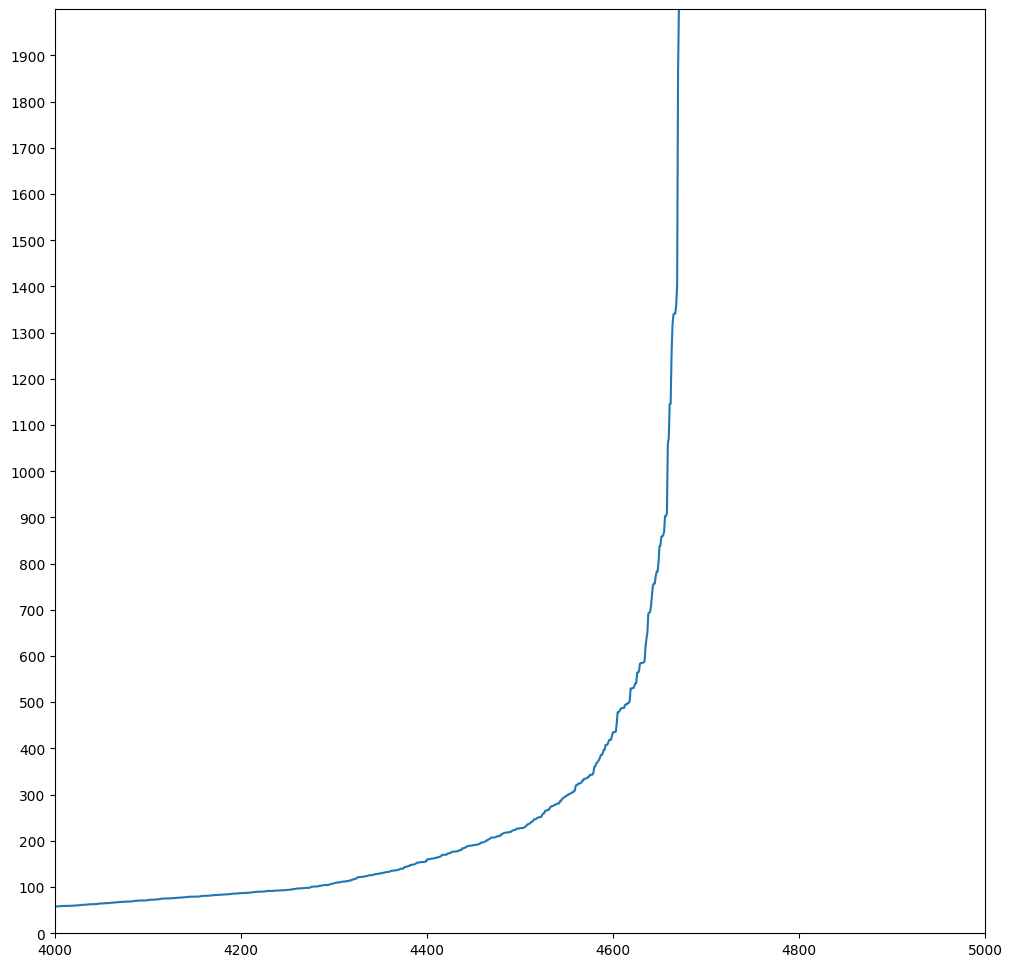

In [221]:
plt.figure(figsize=(12, 12))
plt.plot(distances)
plt.xlim([4000,5000])
plt.ylim([100,2000])
plt.yticks(np.arange(0,2000,100))
plt.ticklabel_format(useOffset=False,style='plain')

In [222]:
dbscan = DBSCAN(eps = 500, min_samples = 4).fit(input) # fitting the model
customer_quantity_price_dbscan = customer_quantity_price[:]
customer_quantity_price_dbscan['DBSCAN'] = dbscan.labels_

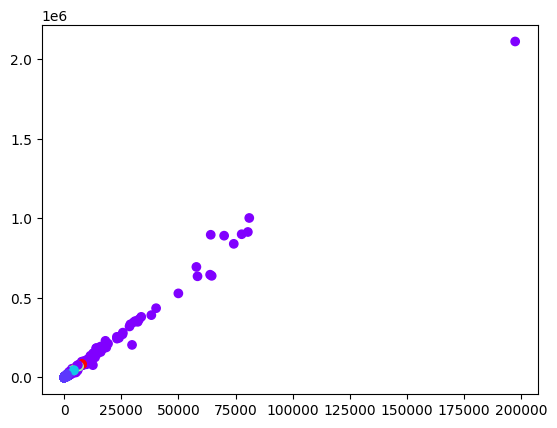

In [223]:
plt.scatter(customer_quantity_price_dbscan['TotalQuantity'],customer_quantity_price_dbscan['TotalMoney'],c=customer_quantity_price_dbscan['DBSCAN'],cmap='rainbow')

## Sau khi bỏ outlier(Chưa hoàn thành)

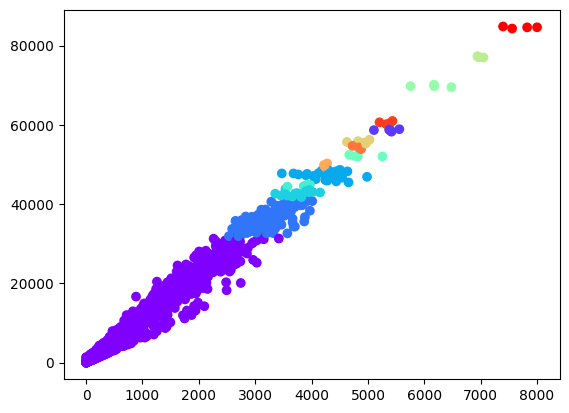

In [224]:
input = customer_quantity_price_dbscan[:]
input = input.loc[input['DBSCAN']!= -1]
plt.scatter(input['TotalQuantity'],input['TotalMoney'],c=input['DBSCAN'],cmap='rainbow')

In [225]:
customer_quantity_price_outlier_dbscan = customer_quantity_price_dbscan.loc[customer_quantity_price_dbscan['DBSCAN']==-1]
customer_quantity_price_outlier_dbscan = customer_quantity_price_outlier_dbscan.drop(customer_quantity_price_outlier_dbscan.columns[3],axis=1)
customer_quantity_price_outlier_dbscan.to_csv("./data/customer_quantity_price_outlier_dbscan.csv",index=False)

## Nhận xét và so sánh 2 thuật toán:

In [226]:
print("Outlier tìm được theo DBSCAN: ",customer_quantity_price_outlier_dbscan.shape[0])
print("Outlier tìm được theo phương pháp số học: ",customer_quantity_price_outlier_statistic.shape[0])

Outlier tìm được theo DBSCAN:  137
Outlier tìm được theo phương pháp số học:  409


## Loại bỏ outlier

In [227]:
customer_quantity_price_without_outlier = customer_quantity_price[~customer_quantity_price.isin(customer_quantity_price_outlier_statistic)]
customer_quantity_price_without_outlier.dropna(inplace=True)

<Axes: xlabel='TotalQuantity'>

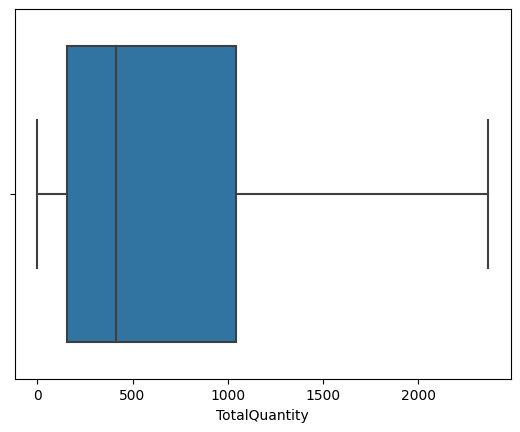

In [228]:
sb.boxplot(x='TotalQuantity',data=customer_quantity_price,showfliers = False)

##

# Tìm các transaction là outlier transaction theo TotalMoney và TotalQuantity

In [229]:
if not exists("./data/transaction_quantity_money.csv"):
    transaction_quantity_money = pd.DataFrame(data.TransactionNo.unique(),columns=(['TransactionNo']))
    transaction_quantity_money['TotalQuantity'] = 0
    transaction_quantity_money['TotalMoney'] = 0
    for x in transaction_quantity_money.TransactionNo:
        totalMoney = data.loc[data['TransactionNo'] == x].Price.sum()
        totalQuantity = data.loc[data['TransactionNo'] == x].Quantity.sum()
        transaction_quantity_money.loc[transaction_quantity_money.TransactionNo == x,'TotalMoney'] = totalMoney
        transaction_quantity_money.loc[transaction_quantity_money.TransactionNo == x,'TotalQuantity'] = totalQuantity
    transaction_quantity_money.to_csv("./data/transaction_quantity_money.csv",index=False)
else: transaction_quantity_money = pd.read_csv("./data/transaction_quantity_money.csv")
transaction_quantity_money.head()

,TransactionNo,TotalQuantity,TotalMoney
0,581482,228,84.78
1,581475,352,213.81
2,581476,2215,825.45
3,581477,144,126.14
4,581478,226,234.92


<Axes: xlabel='TotalQuantity'>

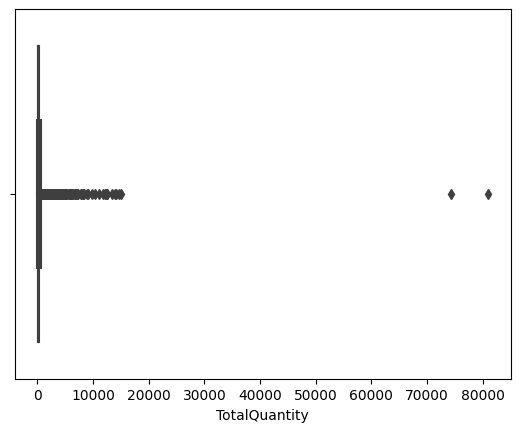

In [230]:
sb.boxplot(x='TotalQuantity',data=transaction_quantity_money)

<Axes: xlabel='TotalMoney'>

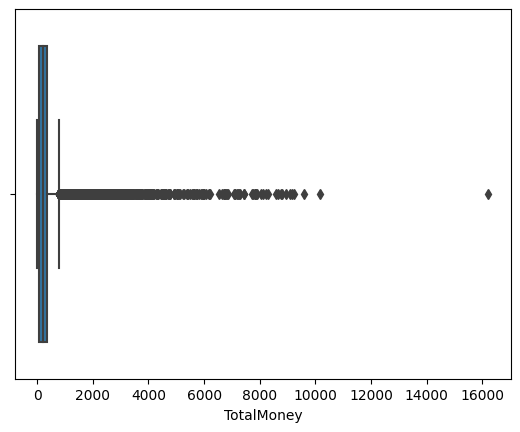

In [231]:
sb.boxplot(x='TotalMoney',data=transaction_quantity_money)

In [232]:
Q1_TotalQuantity = transaction_quantity_money.TotalQuantity.quantile(0.25)
Q3_TotalQuantity = transaction_quantity_money.TotalQuantity.quantile(0.75)
IQR_TotalQuantity = Q3_TotalQuantity - Q1_TotalQuantity
print("Q1_TotalQuantity:  ",Q1_TotalQuantity)
print("Q3_TotalQuantity: ",Q3_TotalQuantity)
print("IQR_TotalQuantity: ",IQR_TotalQuantity)

Q1_TotalQuantity:   71.0
Q3_TotalQuantity:  298.0
IQR_TotalQuantity:  227.0


In [233]:
Q1_TotalMoney = transaction_quantity_money.TotalMoney.quantile(0.25)
Q3_TotalMoney = transaction_quantity_money.TotalMoney.quantile(0.75)
IQR_TotalMoney = Q3_TotalMoney - Q1_TotalMoney
print("Q1_TotalMoney: ",Q1_TotalMoney)
print("Q3_TotalMoney: ",Q3_TotalMoney)
print("IQR_TotalMoney: ",IQR_TotalMoney)


Q1_TotalMoney:  78.54
Q3_TotalMoney:  362.8400000000001
IQR_TotalMoney:  284.30000000000007


In [234]:
transaction_quantity_money_outlier_statistic = transaction_quantity_money.loc[(transaction_quantity_money["TotalQuantity"] < Q1_TotalQuantity-1.5*IQR_TotalQuantity) | (transaction_quantity_money["TotalQuantity"] > Q3_TotalQuantity+1.5*IQR_TotalQuantity)].sort_values(by="TotalQuantity",ascending=False)
transaction_quantity_money_outlier_statistic.append(transaction_quantity_money.loc[(transaction_quantity_money["TotalMoney"] < Q1_TotalMoney-1.5*IQR_TotalMoney) | (transaction_quantity_money["TotalMoney"] > Q3_TotalMoney+1.5*IQR_TotalMoney)].sort_values(by="TotalMoney",ascending=False))
print("Tổng số outlier: ",len(transaction_quantity_money_outlier_statistic))

transaction_quantity_money.to_csv("./data/transaction_quantity_money_outlier_statistic.csv",index=False)

Tổng số outlier:  1448


## Loại bỏ outlier khỏi tập dữ liệu:

<Axes: xlabel='TotalQuantity'>

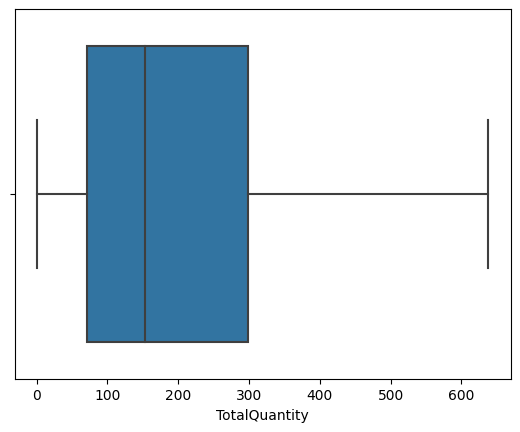

In [235]:
sb.boxplot(x='TotalQuantity',data=transaction_quantity_money,showfliers = False)

<Axes: xlabel='TotalMoney'>

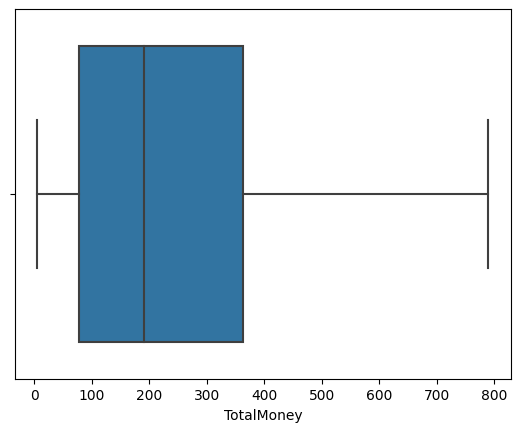

In [236]:
sb.boxplot(x='TotalMoney',data=transaction_quantity_money,showfliers = False)

In [237]:
transaction_quantity_money = transaction_quantity_money.loc[~transaction_quantity_money['TransactionNo'].isin(transaction_quantity_money_outlier_statistic.TransactionNo)]

In [238]:
data_without_outlier = data.loc[~data['TransactionNo'].isin(transaction_quantity_money['TransactionNo'])]

# Vẽ biểu đồ

#### 10 giao dịch có tổng thanh toán cao nhất

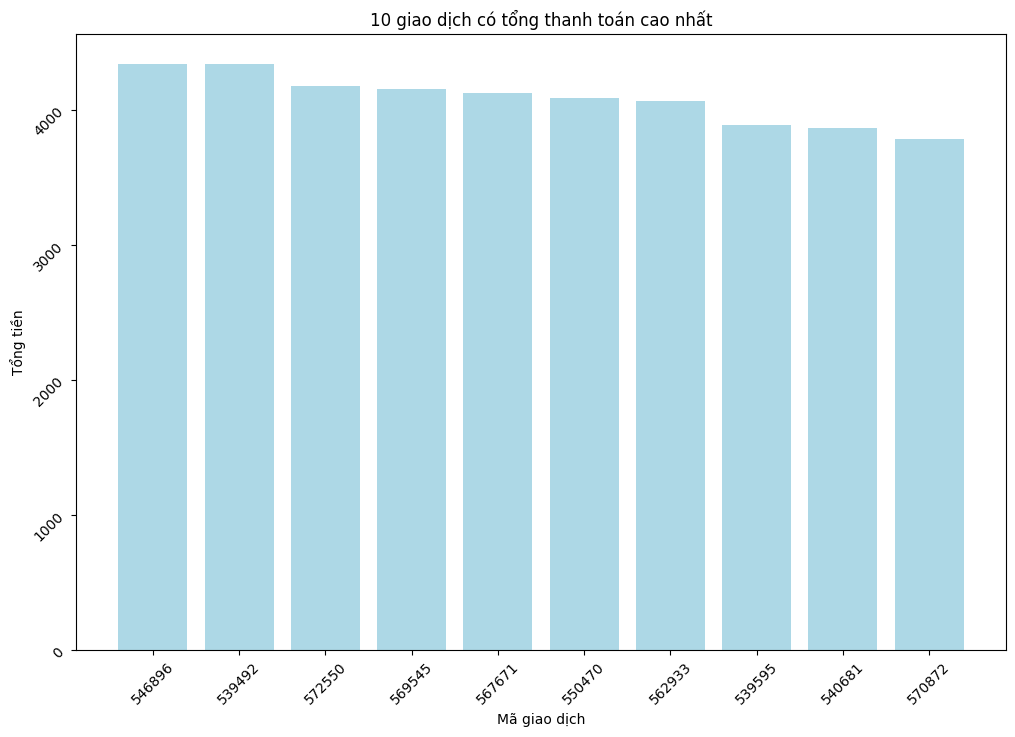

In [239]:
input = transaction_quantity_money.sort_values('TotalMoney',ascending=False).head(10)
input = input.reset_index(drop=True)

# Create Figure
plt.figure(figsize = (12,8))
plt.bar(input.TransactionNo.astype(str),input.TotalMoney, color = 'lightblue')
plt.title('10 giao dịch có tổng thanh toán cao nhất')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Mã giao dịch')
plt.ylabel('Tổng tiền')
plt.show()

#### 10 sản phẩm có doanh thu cao nhất

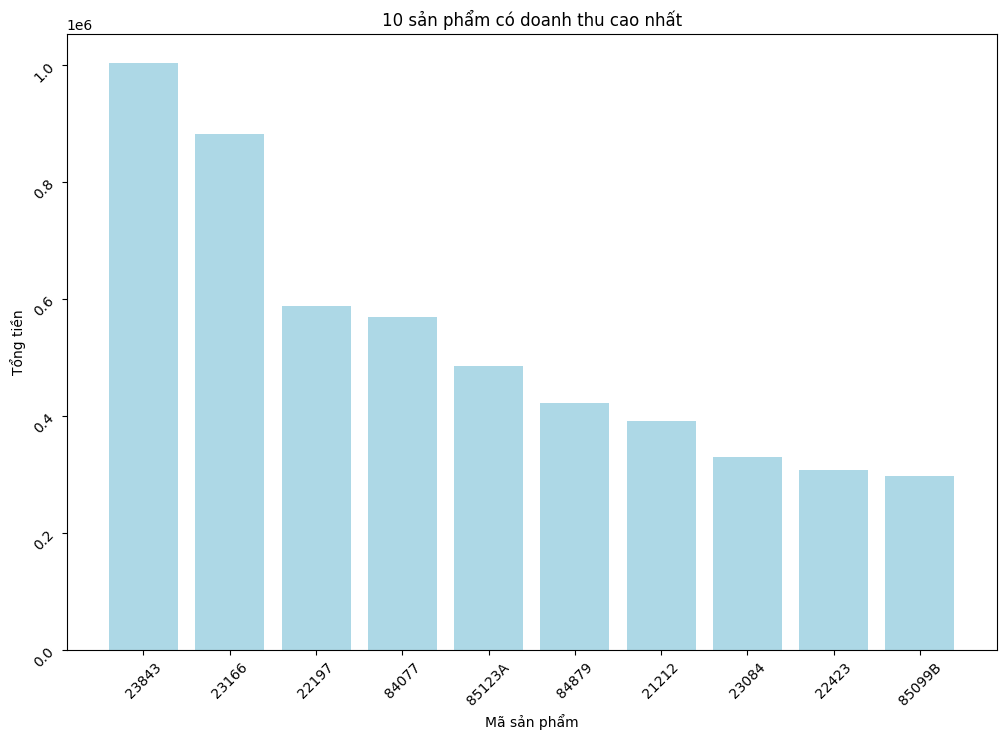

  ProductNo  TotalMoney                         ProductName
0     23843  1002718.10           Paper Craft Little Birdie
1     23166   881990.18      Medium Ceramic Top Storage Jar
2     22197   587433.94                      Popcorn Holder
3     84077   569735.39   World War 2 Gliders Asstd Designs
4    85123A   484592.69  Cream Hanging Heart T-Light Holder
5     84879   421318.74       Assorted Colour Bird Ornament
6     21212   391485.03     Pack Of 72 Retrospot Cake Cases
7     23084   329029.89                  Rabbit Night Light
8     22423   307483.85            Regency Cakestand 3 Tier
9    85099B   297205.04             Jumbo Bag Red Retrospot


In [240]:
# Variable to Store Data
listProduct = data_without_outlier['ProductNo'].unique()
listTotalMoney = []

# Loop for Store Data
for i in listProduct:
    totalMoney = data_without_outlier['TotalMoney'].loc[data_without_outlier['ProductNo'] == i].sum()
    listTotalMoney.append(totalMoney)

# Dictionary for DataFrame
dictProduct = {
    'ProductNo' : listProduct,
    'TotalMoney' : listTotalMoney
}

# Adjust DataFrame
dfProduct = pd.DataFrame(dictProduct)
dfProduct = dfProduct.sort_values('TotalMoney',ascending=False).head(10)
dfProduct = dfProduct.reset_index(drop=True)

# Create Figure
plt.figure(figsize = (12,8))
plt.bar(data = dfProduct, x = 'ProductNo',height = 'TotalMoney', color = 'lightblue')
plt.title('10 sản phẩm có doanh thu cao nhất')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Mã sản phẩm')
plt.ylabel('Tổng tiền')
plt.show()

# Show Product Number, Product Name and Total Money
listProductName = []
for i in dfProduct['ProductNo']:
    a = data_without_outlier['ProductName'].loc[data_without_outlier ['ProductNo'] == i].unique()[0]
    listProductName.append(a) 
dfProduct['ProductName'] = listProductName
print(dfProduct)

#### Giá của 10 sản phẩm có doanh thu cao nhất

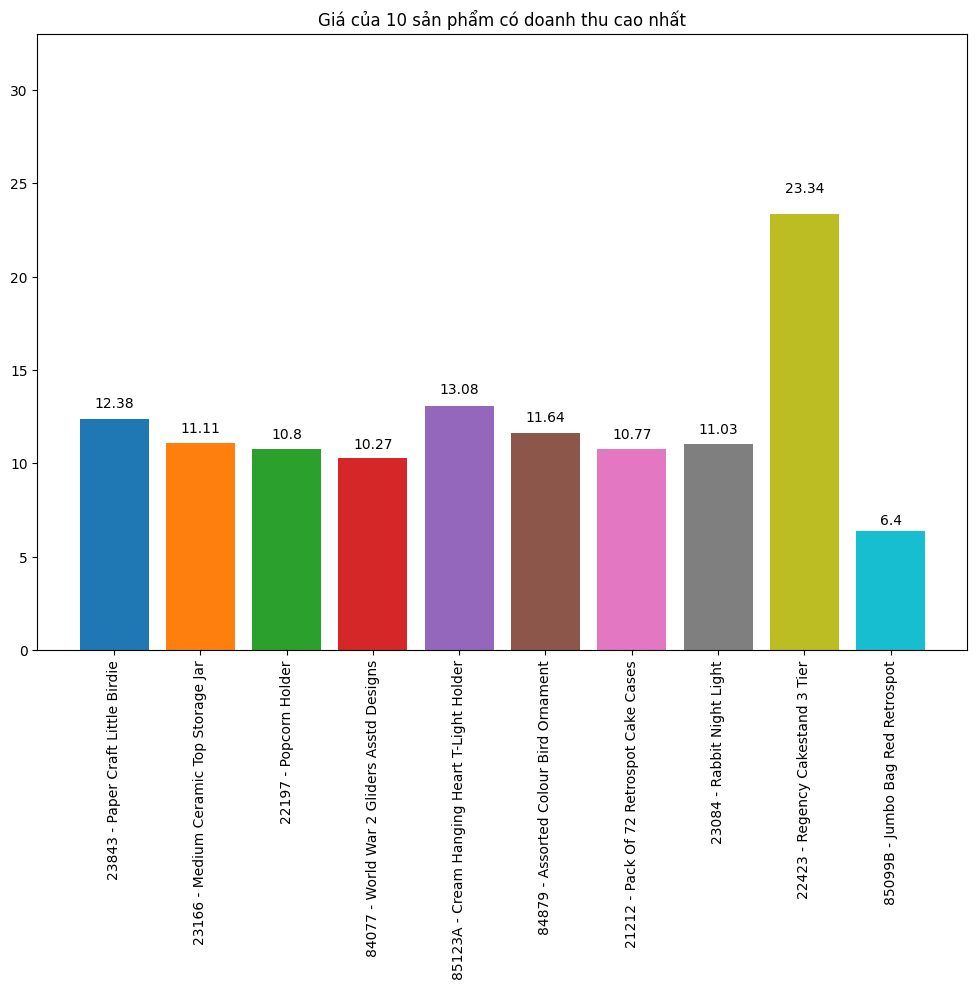

In [241]:
plt.figure(figsize=(12,8))

listProductNo = dfProduct['ProductNo'].unique().copy()
listProductName = dfProduct['ProductName'].unique().copy()

for i in range(len(listProductNo)):
    pricePiece = round(data_without_outlier['Price'].loc[data_without_outlier['ProductNo']==listProductNo[i]].mean(),2)
    labelx = listProductNo[i]+' - '+listProductName[i]
    plt.text(labelx,pricePiece*1.05,pricePiece,ha='center')
    plt.bar(x = labelx, height = pricePiece)

plt.ylim(0,33)
plt.title('Giá của 10 sản phẩm có doanh thu cao nhất')
plt.xticks(rotation = 90)
plt.show()

#### Tổng số lượng bán ra của 10 sản phẩm có doanh thu cao nhất

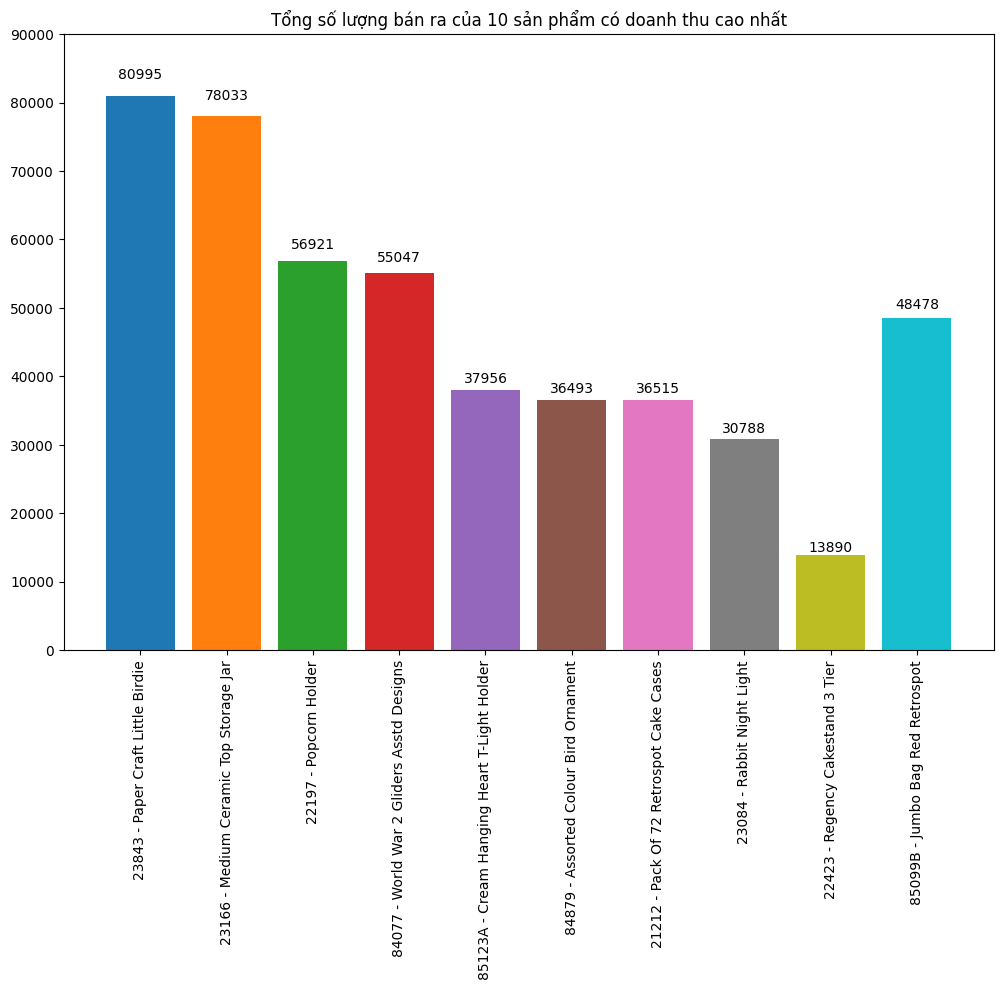

In [242]:
plt.figure(figsize=(12,8))

listProductNo = dfProduct['ProductNo'].unique().copy()
listProductName = dfProduct['ProductName'].unique().copy()

for i in range(len(listProductNo)):
    totalQuantity = round(data_without_outlier['Quantity'].loc[data_without_outlier['ProductNo']==listProductNo[i]].sum(),2)
    labelx = listProductNo[i]+' - '+listProductName[i]
    plt.text(labelx,totalQuantity*1.03,totalQuantity,ha='center')
    plt.bar(x = labelx, height = totalQuantity)

plt.ylim(0,90000)
plt.title('Tổng số lượng bán ra của 10 sản phẩm có doanh thu cao nhất')
plt.xticks(rotation = 90)
plt.show()

#### 10 quốc gia có doanh số mua hàng cao nhất

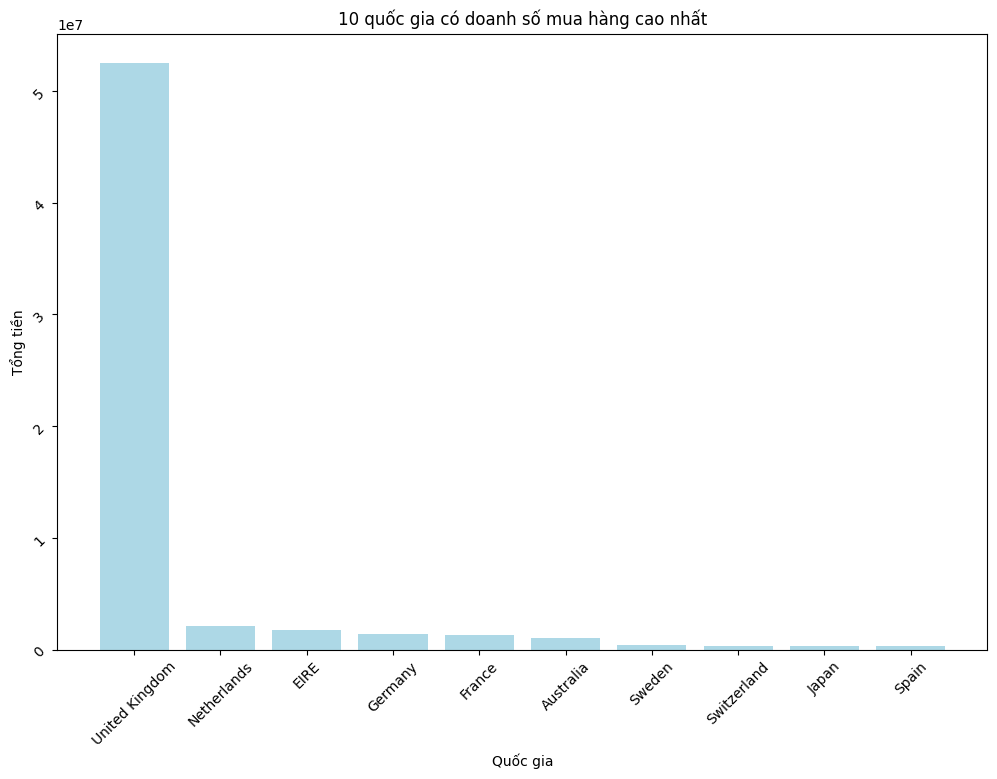

      CountryName   TotalMoney
0  United Kingdom  52524576.47
1     Netherlands   2151553.59
2            EIRE   1713410.95
3         Germany   1371543.27
4          France   1330652.89
5       Australia    995607.91
6          Sweden    401879.89
7     Switzerland    361969.25
8           Japan    293155.44
9           Spain    281012.27


In [243]:
# Variable to Store
listCountry = data_without_outlier['Country'].unique()
listTotalMoney = []

# Loop to Store Data
for i in listCountry:
    totalMoney = round(data_without_outlier['TotalMoney'].loc[data_without_outlier['Country'] == i].sum(),2)
    listTotalMoney.append(totalMoney)

# Dictionary for Dataframe
dictCountry = {
    'CountryName' : listCountry,
    'TotalMoney' : listTotalMoney
}

# Adjust Data Frame
dfCountry = pd.DataFrame(dictCountry)
dfCountry = dfCountry.sort_values('TotalMoney',ascending = False).head(10)
dfCountry = dfCountry.reset_index(drop = True)

# Create Figure
plt.figure(figsize = (12,8))
plt.bar(data = dfCountry, x = 'CountryName',height = 'TotalMoney', color = 'lightblue')
plt.title('10 quốc gia có doanh số mua hàng cao nhất')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Quốc gia')
plt.ylabel('Tổng tiền')
plt.show()

# Show dfCountry
print(dfCountry)

#### Tổng doanh thu của từng tháng trong năm 2019

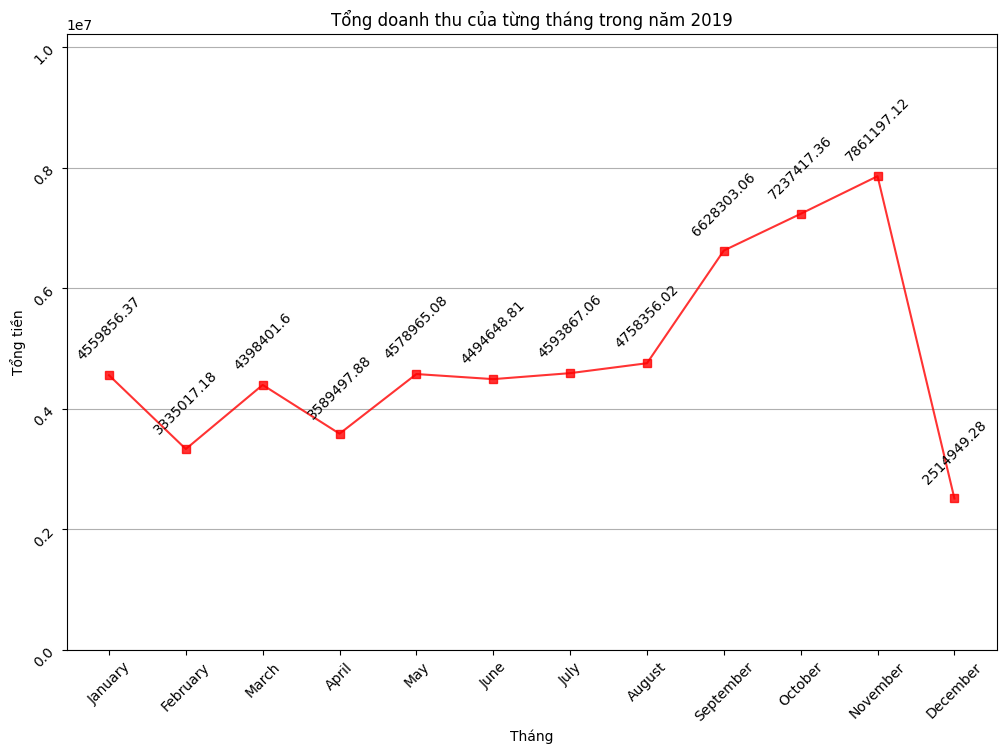

In [244]:
# Variable to Store
listMonth = []
listTotalMoney = []
for i in data_without_outlier['Month'].unique():
    monthName = dt.datetime.strptime(str(i), "%m")
    monthName = monthName.strftime("%B")
    listMonth.append(monthName)
for i in data_without_outlier['Month'].unique():
    totalMoney = round(data_without_outlier['TotalMoney'].loc[(data_without_outlier['Month']==i)&(data_without_outlier['Year']==2019)].sum(),2)
    listTotalMoney.append(totalMoney)
    
# Dictionary for DataFrame
dictMonth = {
    'MonthName' : listMonth,
    'TotalMoney' : listTotalMoney
}

# Adjust Data Frame
dfMonth = pd.DataFrame(dictMonth)
dfMonth = dfMonth.iloc[::-1]


# Create Figure
plt.figure(figsize = (12,8))
plt.plot(dfMonth['MonthName'], dfMonth['TotalMoney'], color = 'Red', marker = 's',alpha = 0.8)
plt.title('Tổng doanh thu của từng tháng trong năm 2019')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Tháng')
plt.ylabel('Tổng tiền')
for i in dfMonth['MonthName']: 
    text = str(dfMonth['TotalMoney'].loc[dfMonth['MonthName'] == i].values[0])
    y = dfMonth['TotalMoney'].loc[dfMonth['MonthName'] == i]+(dfMonth['TotalMoney'].min()*0.1)
    plt.text(i,y,text, ha = 'center', rotation = 45) 
plt.ylim(0,dfMonth['TotalMoney'].max()*1.3)
plt.grid(axis = 'y')
plt.show()

In [245]:
def searchTotalMoney(country,month):
    return round(data_without_outlier['TotalMoney'].loc[(data_without_outlier['Country'] == country)&(data_without_outlier['Month'] == month)].sum(),2)

def searchHighestTotalMoneyCountry(month):
    listMoney = []
    maxCountry = 'none'
    for i in listCountry:
        total = searchTotalMoney(i,month)
        listMoney.append(total)
        maxMoney = max(listMoney) 
        if total >= maxMoney:
            maxCountry = i 
    return([maxMoney,maxCountry])

listTotalMoney = []
listHighCountry = []

for i in data_without_outlier['Month'].unique():
    templist = searchHighestTotalMoneyCountry(i)
    listTotalMoney.append(templist[0])
    listHighCountry.append(templist[1])

dictHighCountMonth = {
    'Month' : listMonth,
    'Country Name' : listHighCountry,
    'Total Money' : listTotalMoney
}             

dfCountMonth = pd.DataFrame(dictHighCountMonth)
dfCountMonth = dfCountMonth.iloc[::-1]
dfCountMonth = dfCountMonth.reset_index(drop = True)
dfCountMonth

,Month,Country Name,Total Money
0,January,United Kingdom,3671367.43
1,February,United Kingdom,2726550.00
2,March,United Kingdom,3576781.25
3,April,United Kingdom,3213814.52
4,May,United Kingdom,3736303.18
5,June,United Kingdom,3579635.41
6,July,United Kingdom,3836352.99
7,August,United Kingdom,3776324.77
8,September,United Kingdom,5560902.08
9,October,United Kingdom,5862341.38


#### Tổng số tiền mỗi tháng bán được từ 10 quốc gia có tổng doanh số bán cao nhất trong năm 2019

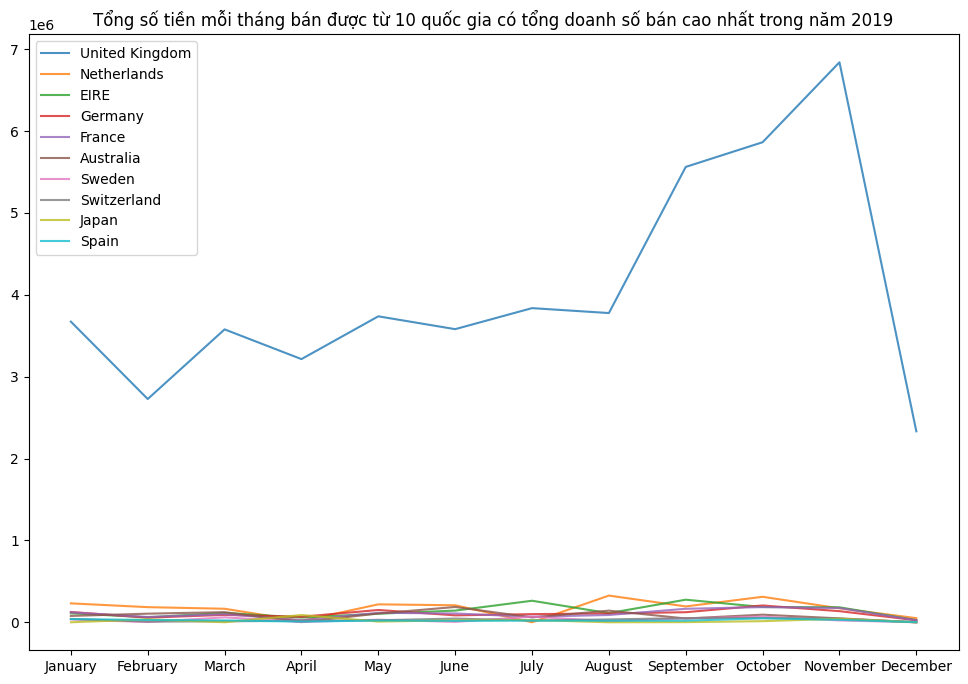

In [246]:
plt.figure(figsize = (12,8))
topTenCountry = dfCountry['CountryName'].unique().copy()
listMonthTopTen = listMonth.reverse()
listMonthTopTen = listMonth 

for i in topTenCountry:
    totalMoneyCountry = []
    for j in data_without_outlier['Month'].unique():
        moneyCountry = round(data_without_outlier['TotalMoney'].loc[(data_without_outlier['Country']==i)&((data_without_outlier['Month']==j)&(data_without_outlier['Year']==2019))].sum(),2)
        totalMoneyCountry.append(moneyCountry)
    totalMoneyCountry.reverse()
    plt.plot(listMonthTopTen, totalMoneyCountry,alpha = 0.8) 

plt.title('Tổng số tiền mỗi tháng bán được từ 10 quốc gia có tổng doanh số bán cao nhất trong năm 2019')
plt.legend(topTenCountry)
plt.show()

#### Tổng tiền mỗi tháng bán được từ 10 sản phẩm hàng đầu có doanh thu cao nhất trong năm 2019

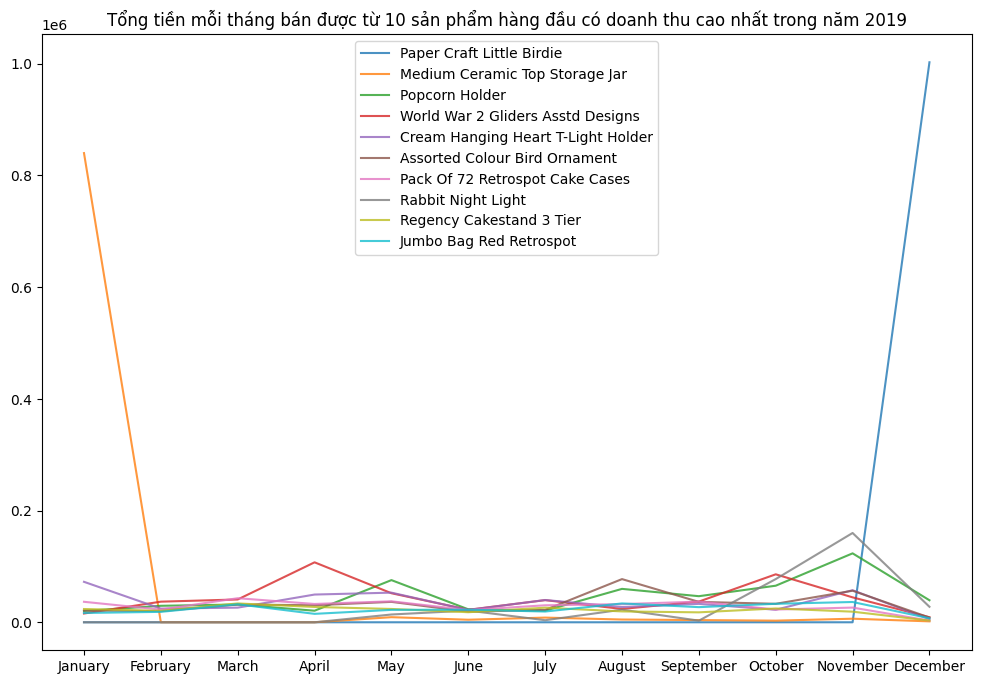

In [247]:
plt.figure(figsize = (12,8))
listProductNo = dfProduct['ProductNo'].unique().copy()  
listProductName = dfProduct['ProductName'].unique().copy()

for i in listProductNo:
    totalMoneyCountry = []
    for j in data_without_outlier['Month'].unique():
        moenyCountry = round(data_without_outlier['TotalMoney'].loc[(data_without_outlier['ProductNo']==i)&((data_without_outlier['Month']==j)&(data_without_outlier['Year']==2019))].sum(),2)
        totalMoneyCountry.append(moenyCountry)
    totalMoneyCountry.reverse()
    plt.plot(listMonthTopTen, totalMoneyCountry,alpha = 0.8) 

plt.title('Tổng tiền mỗi tháng bán được từ 10 sản phẩm hàng đầu có doanh thu cao nhất trong năm 2019')
plt.legend(listProductName)
plt.show()

#### Tổng số lượng mỗi tháng bán được từ 10 sản phẩm có doanh thu cao nhất trong năm 2019

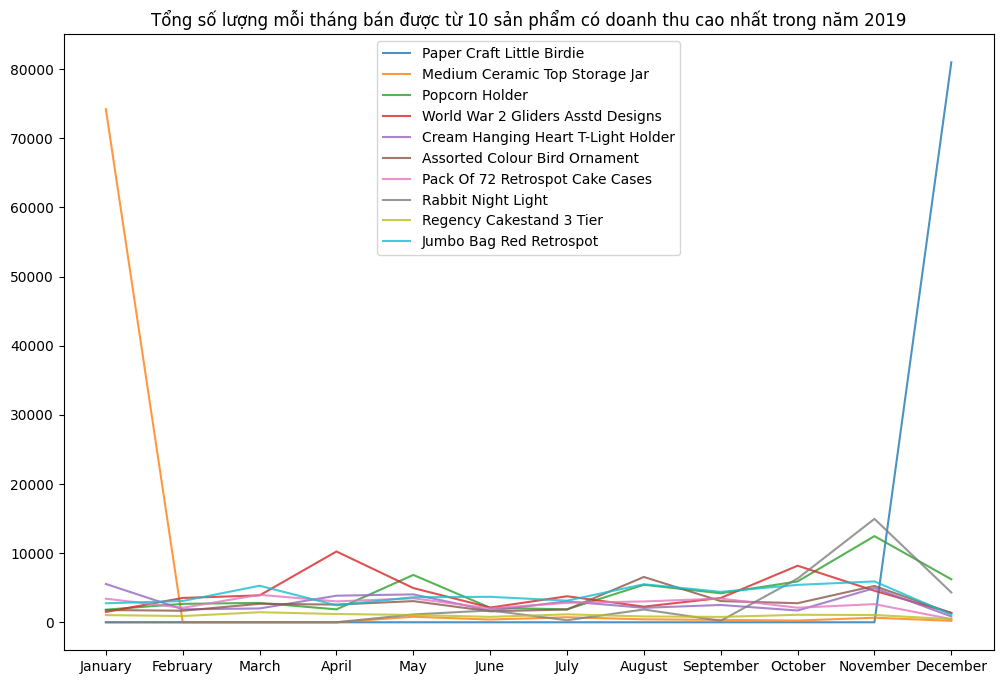

In [248]:
plt.figure(figsize = (12,8))
listProductNo = dfProduct['ProductNo'].unique().copy()  
listProductName = dfProduct['ProductName'].unique().copy()

for i in listProductNo:
    totalMoneyCountry = []
    for j in data_without_outlier['Month'].unique():
        moenyCountry = round(data_without_outlier['Quantity'].loc[(data_without_outlier['ProductNo']==i)&((data_without_outlier['Month']==j)&(data_without_outlier['Year']==2019))].sum(),2)
        totalMoneyCountry.append(moenyCountry)
    totalMoneyCountry.reverse()
    plt.plot(listMonthTopTen, totalMoneyCountry,alpha = 0.8) 

plt.title('Tổng số lượng mỗi tháng bán được từ 10 sản phẩm có doanh thu cao nhất trong năm 2019')
plt.legend(listProductName)
plt.show()

# Trả lời những câu hỏi đặt ra:
#### Xu hướng bán hàng thay đổi qua từng tháng như thế nào?
Dựa vào biểu đồ **'Tổng doanh thu từng tháng trong năm 2019'**, doanh số của doanh nghiệp này tăng tương đối hàng tháng kể từ tháng 1, nhưng vào tháng 12 năm 2019, doanh số giảm đáng kể. Có thể giải thích sự giảm này dựa vào biểu đồ **'Tổng số tiền mỗi tháng bán được từ 10 quốc gia có tổng doanh số bán cao nhất trong năm 2019'**, có thể thấy doanh số bán đến Anh vào tháng 12 năm 2019 cũng đã bị giảm, thực ra không phải do doanh nghiệp không bán được hàng, mà là do tập dữ liệu nhóm sử dụng ở đây chỉ cập nhật đến ngày 9/12/2019 cho nên không tổng quát được tháng 12.

#### Những sản phẩm được mua thường xuyên nhất là gì?
Dựa vào biểu đồ **'10 sản phẩm có doanh số cao nhất'**, các sản phẩm được mua nhiều nhất và mang lại lợi nhuận cao là *Paper Craft Little Birdie, Medium Ceramic Top Storage Jar, Popcorn Holder, World War 2 Gliders Asstd Designs, Cream Hanging Heart T-Light Holder, Assorted Colour Bird Ornament, Pack Of 72 Retrospot Cake Cases, Rabbit Night Light, Regency Cakestand 3 Tier, Jumbo Bag Red Retrospot*.
Ta có thể thấy mặt hàng trang trí được bán khá chạy, gồm các tấm thiệp, hay là những đồ decor trong phòng, cho nên phân loại này cần được mở rộng hơn, đa dạng hơn với nhiều mẫu mã, màu sắc. Ngoài ra, phân loại sản phẩm bán chạy thứ 2 gồm những phân loại hộp đựng thức ăn, hay là dụng cụ nhà bếp, có thể dựa vào biểu đổ **'Tổng số lượng bán ra của 10 sản phẩm có doanh số cao nhất'** mà thấy rằng những mặt hàng này được bán với số lượng rất lớn, mang lại doanh thu khá cao cho doanh nghiệp, ta sẽ cần phân tích sâu hơn trên phân loại này cũng như là mở rộng quy mô bán lẻ.

Dựa vào biểu đồ **'Tổng tiền mỗi tháng bán được từ 10 sản phẩm hàng đầu có doanh thu cao nhất trong năm 2019'**, ta có thể thấy 2 sản phẩm đứng đầu có doanh số bán khá lạ

Ở đây, sản phẩm đứng đầu doanh số là Paper Craft Little Birdie, nhưng sau vài bước kiểm tra, thì nhóm nhận ra chỉ có 1 khách hàng mua với 1 đơn hàng với 80995 sản phẩm, lúc này, ta nên loại sản phẩm này ra khỏi top 10 sản phẩm bởi vì không còn tính tổng quát.

Tương tự với sản phẩm đứng thứ 2, Medium Ceramic Top Storage Jar.

#### Mỗi giao dịch khách hàng thường mua bao nhiêu sản phẩm?
Dựa vào biểu đồ **'10 giao dịch có tổng thanh toán cao nhất'**, khách hàng dường như mua số lượng sản phẩm khác nhau dựa trên nhu cầu của họ, nhưng ở đây chúng ta có thể thấy sự khác biệt có thể rất đáng kể. Sau một vài bước kiểm tra thì hầu như nhưng giao dịch này đều được thực hiện vào năm 2019, với số lượng sản phẩm khá cao, hầu như mỗi đơn hàng đều gần 300 mặt hàng khác nhau.

#### Đâu là phân khúc khách hàng có lợi nhuận cao nhất?
Nhóm khách hàng mang lại lợi nhuận cao nhất là nhóm khách hàng mua sản phẩm được bao gồm trong biểu đồ **'Giá của 10 sản phẩm có doanh thu cao nhất'**, biểu đồ **'Tổng số lượng bán ra của 10 sản phẩm có doanh số nhất'** và biểu đồ **'10 sản phẩm có doanh thu cao nhất'**, cùng với nhóm khách hàng đến từ quốc gia được bao gồm trong biểu đồ **'10 quốc gia có doanh số bán cao nhất'**.

Có thể thấy Vương Quốc Anh là thị trường khá màu mỡ, nên mở rộng thêm những siêu thị bán lẻ ở quốc gia này.

#### Dựa trên những câu hỏi trên, có thể đề xuất chiến lược nào cho doanh nghiệp để thu được nhiều lợi nhuận hơn?
Dựa trên những phát hiện, có một số chiến lược để doanh nghiệp đạt được lợi nhuận cao hơn.

Thứ nhất, dựa trên biểu đồ **'Tổng số lượng bán ra của 10 sản phẩm có doanh số nhất'** cùng với **'10 sản phẩm có doanh số bán cao nhất'**, doanh nghiệp nên mở rộng 2 loại sản phẩm là trang trí, và đồ dùng nhà bếp, những phân loại mang lại doanh số cao nhất trong khoảng thời gian phân tích.

Thứ hai, tăng doanh số bán hàng, cũng như là cải thiện chất lượng cho các sản phẩm được bao gồm trong biểu đồ **'10 sản phẩm có doanh số bán cao nhất'** bằng các phương pháp tiếp thị đa dạng để thu hút người mua.

Thứ ba, tăng doanh số bán hàng tại các quốc gia được bao gồm trong biểu đồ **'10 quốc gia có doanh số bán cao nhất'** bằng các phương pháp tiếp thị đa dạng, quảng cáo các sản phẩm tại các quốc gia không được bao gồm để thu hút và tăng sự quan tâm của người mua từ những quốc gia này.

# Tìm các outlier khách hàng mua hàng số lượng nhiều

# Thuật toán Gom cụm

Text(0, 0.5, 'WCSS')

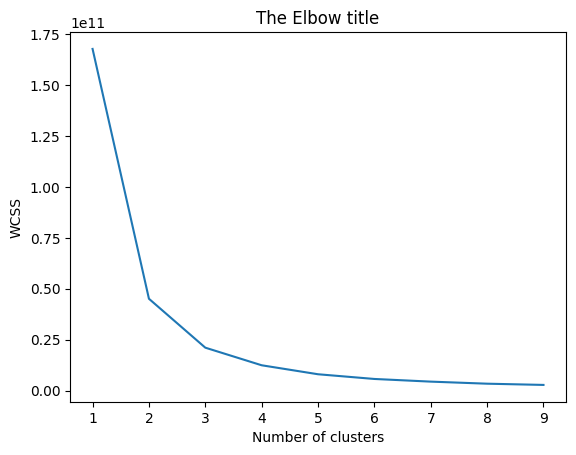

In [ ]:
wcss=[] #is the sum of the squared distance between each point and the centroid in a cluster.
for i in range (1,10):
    kmeans = KMeans(i)
    kmeans.fit(customer_quantity_price_without_outlier.iloc[:,1:3])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
kmeans = KMeans(3)
kmeans.fit(customer_quantity_price_without_outlier.iloc[:,1:3])#Lấy 2 cột totalquantity và total price làm input
identified_clusters = kmeans.fit_predict(customer_quantity_price_without_outlier.iloc[:,1:3])
customer_quantity_price_without_outlier['Clusters'] = identified_clusters
customer_quantity_price_without_outlier.head()

,CustomerNo,TotalQuantity,TotalPrice,Clusters
0,17490.0,1134.0,13538.07,1
3,13426.0,2245.0,25893.59,2
5,14441.0,446.0,6326.48,1
8,17001.0,2164.0,21680.74,2
9,15694.0,1680.0,21902.34,2


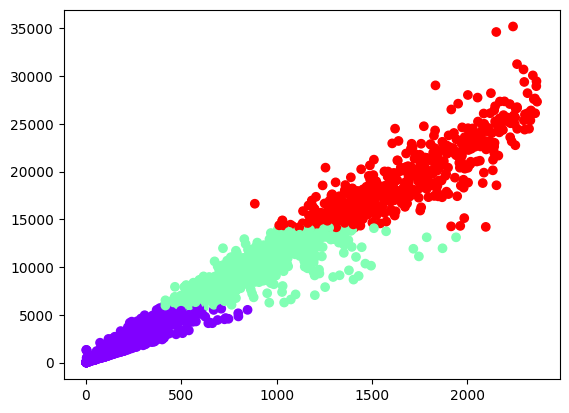

In [ ]:
#Cần thêm xlab và ylab
plt.scatter(customer_quantity_price_without_outlier['TotalQuantity'],customer_quantity_price_without_outlier['TotalMoney'],c=customer_quantity_price_without_outlier['Clusters'],cmap='rainbow')

# Thuật toán FP-Growth

In [ ]:
if not exists("./transactionEncoder.csv"):
    transactionFreq = []
    for i in data['TransactionNo'].unique():#Với mỗi transactionNo
        transactionFreqRow = []
        quantity = data[data['TransactionNo'] == i]['Quantity'].to_list()
        productNo = data[data['TransactionNo'] == i]['ProductNo'].to_list()
        for j in range(len(productNo)): # Với mỗi productNo
            transactionFreqRow.extend(repeat(productNo[j],quantity[j]))
        transactionFreq.append(transactionFreqRow)
    transactionEncoder = TransactionEncoder()
    transactionEncoder_array = transactionEncoder.fit(transactionFreq).transform(transactionFreq)
    transactionEncoder_df = pd.DataFrame(transactionEncoder_array,columns=transactionEncoder.columns_)
    transactionEncoder_df.to_csv("./data/transactionEncoder.csv", sep=',', encoding='utf-8')
else: transactionEncoder_df = pd.read_csv("./transactionEncoder.csv");


In [ ]:
transactionEncoder_df.drop(transactionEncoder_df.iloc[:,0:1],inplace=True, axis=1)

In [ ]:
frequentItemset = fpgrowth(transactionEncoder_df,min_support=0.01, use_colnames=True)
frequentItemset

,support,itemsets
0,0.040314,(22138)
1,0.032718,(23300)
2,0.017049,(22371)
3,0.012819,(22721)
4,0.012733,(22723)
...,...,...
1346,0.012172,"(20711, 22386)"
1347,0.010186,"(21931, 20711, 85099B)"
1348,0.010057,"(20711, 22386, 85099B)"
1349,0.012129,"(22579, 22578)"


In [ ]:
frequentItemset.to_csv("./data/apriori.csv", sep=',', encoding='utf-8')